# CNN (new)

In [12]:
%matplotlib inline 
import numpy as np
import pandas as pd


import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, regularizers,Model, utils
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
%load_ext tensorboard

import plotly.express as px
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets

from datetime import datetime,time
from pathlib import Path
import pickle

from livelossplot import PlotLossesKeras

from scipy.ndimage.filters import gaussian_filter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load Data

In [3]:
dbfile = open('otherLargeFiles/CNN-dataset.pkl', 'rb')     
dataset = pickle.load(dbfile)
dbfile.close()

In [4]:
dataset["samples"].shape

(34374, 10, 13)

## Split into training/validation

In [5]:
longitudeLabels = dataset["labels"][:,0]
latitudeLabels = dataset["labels"][:,1]

combinedLabels = np.concatenate((np.reshape(longitudeLabels, (-1,1)), np.reshape(latitudeLabels, (-1,1))), axis=1)
trainInputs, testInputs, trainLabels, testLabels = train_test_split(dataset["samples"], combinedLabels, test_size=0.5, shuffle=False)
trainInputs, valInputs, trainLabels, valLabels = train_test_split(trainInputs, trainLabels, test_size=0.15, shuffle=False)

In [6]:
trainInputs.shape

(14608, 10, 13)

## Construct

In [7]:
#specify input dimensionality
outputDimension = 2
sequenceLength = trainInputs.shape[1]

#construct our neural network
convActivation = "relu"
kernelSize = 5
batchSize = 32
dropoutRate = 0.3

def convolutionalLayer(size, name):
    return layers.Conv1DTranspose(size, kernel_size=kernelSize, activation=convActivation, name=name, kernel_regularizer=regularizers.l2(1e-4), padding="same")

inputLayer = layers.Input(shape=(sequenceLength, trainInputs.shape[2]), name="input")
modelLayers = [inputLayer]

def layerByName(n):
    for layer in modelLayers:
        if layer.name.split("/")[0] == n:
            return layer
    return None


modelLayers.append(convolutionalLayer(32,"conv0")(modelLayers[-1]))
modelLayers.append(convolutionalLayer(64,"conv1")(modelLayers[-1]))

modelLayers.append(layers.Concatenate(name="concat0")([layerByName("conv0"), layerByName("conv1")]))
modelLayers.append(convolutionalLayer(128,"conv2")(modelLayers[-1]))

modelLayers.append(layers.Flatten(name="flatten1")(modelLayers[-1]))
outputLayer = layers.Dense(outputDimension, activation='sigmoid', name="output")(modelLayers[-1])

## Compile

In [8]:
combinedModel = Model(inputs=inputLayer, outputs=[outputLayer], name='combined_cnn')
combinedModel.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
combinedModel.save('model.h5')
combinedModel.summary()


Model: "combined_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10, 13)]     0                                            
__________________________________________________________________________________________________
conv0 (Conv1DTranspose)         (None, 10, 32)       2112        input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv1DTranspose)         (None, 10, 64)       10304       conv0[0][0]                      
__________________________________________________________________________________________________
concat0 (Concatenate)           (None, 10, 96)       0           conv0[0][0]                      
                                                                 conv1[0][0]           

## Train

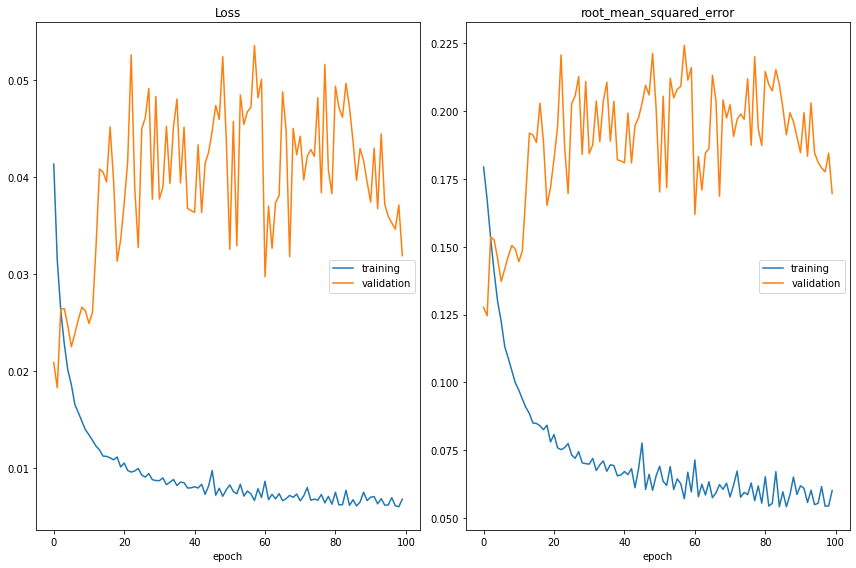

Loss
	training         	 (min:    0.006, max:    0.041, cur:    0.007)
	validation       	 (min:    0.018, max:    0.054, cur:    0.032)
root_mean_squared_error
	training         	 (min:    0.054, max:    0.179, cur:    0.060)
	validation       	 (min:    0.125, max:    0.224, cur:    0.170)


In [9]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
combinedHistory = combinedModel.fit(trainInputs, trainLabels, epochs=100, batch_size=batchSize, callbacks=[PlotLossesKeras(),tensorboard_callback], validation_data=(valInputs, valLabels))

## Test

### Predict Test Set

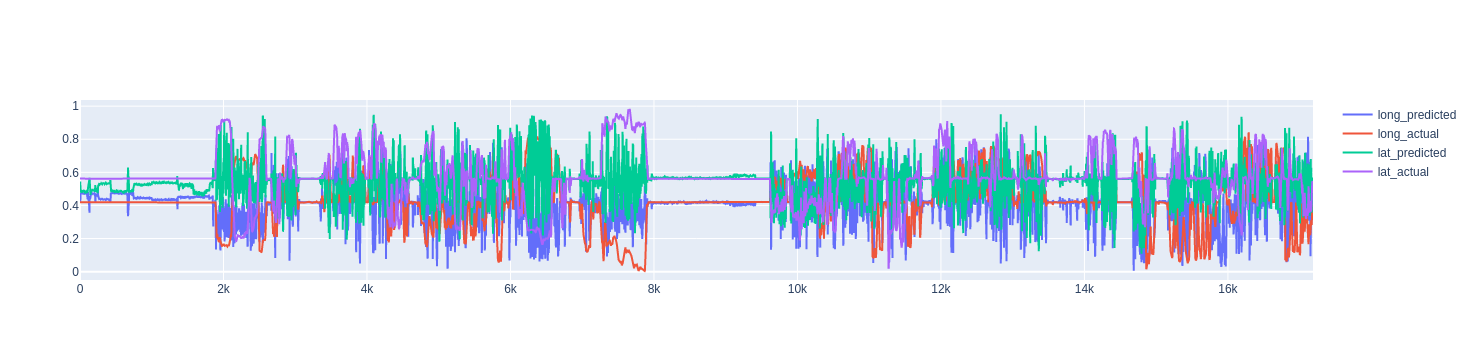

In [20]:
predictions = combinedModel.predict(testInputs)

scatterData = pd.DataFrame({
    "index":np.arange(predictions[:,0].shape[0]),
    "long_predicted": predictions[:,0].reshape(predictions[:,0].shape[0]),
    "long_actual": testLabels[:,0].reshape(testLabels[:,0].shape[0]),
    "lat_predicted": predictions[:,1].reshape(predictions[:,1].shape[0]),
    "lat_actual": testLabels[:,1].reshape(testLabels[:,1].shape[0])
})

fig = go.Figure()
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.long_predicted, name="long_predicted"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.long_actual, name="long_actual"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.lat_predicted, name="lat_predicted"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.lat_actual, name="lat_actual"))

### Predict Training Set

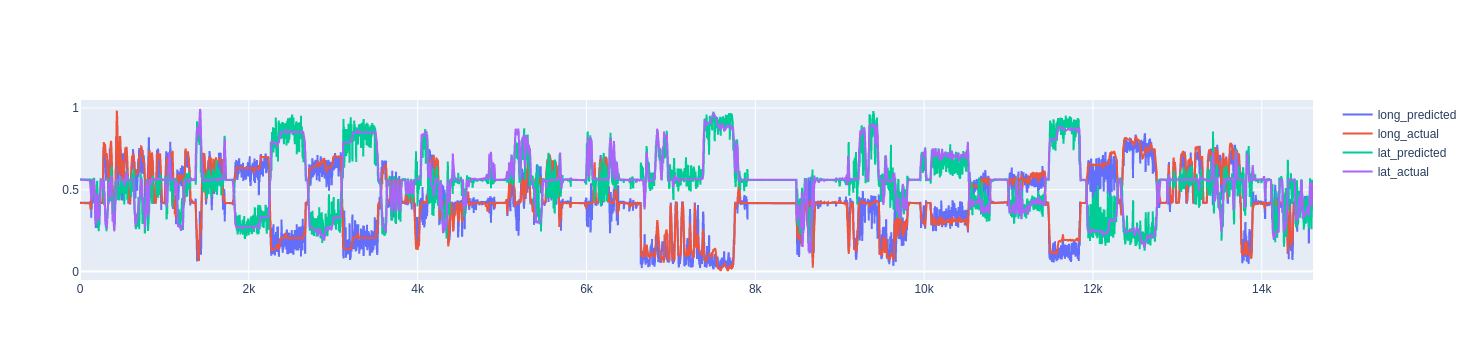

In [19]:
predictions = combinedModel.predict(trainInputs)

scatterData = pd.DataFrame({
    "index":np.arange(predictions[:,0].shape[0]),
    "long_predicted": predictions[:,0].reshape(predictions[:,0].shape[0]),
    "long_actual": trainLabels[:,0].reshape(trainLabels[:,0].shape[0]),
    "lat_predicted": predictions[:,1].reshape(predictions[:,1].shape[0]),
    "lat_actual": trainLabels[:,1].reshape(trainLabels[:,1].shape[0])
})

fig = go.Figure()
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.long_predicted, name="long_predicted"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.long_actual, name="long_actual"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.lat_predicted, name="lat_predicted"))
fig.add_trace(go.Scatter(x=scatterData.index, y=scatterData.lat_actual, name="lat_actual"))